# Bayesian Networks and Flight Delay : SFO to PHL

Flight delay is a costly problem to consumers, airlines, and industrial experts. Delays provoke complaints from passengers, create high costs to airlines, and result in difficulties for airport operations. It is therefore important for the Federal Aviation Administration (FAA) to understand the causes of delay as a means to reduce the total cost that delays can cause.

Known factors that cause flight delays include weather at the origin airport, congestion at the origin airport, and air traffic management (ATM) decisions such as Ground Delay Programs (GDP). Each component interacts with other components in complex ways, which is why flight delays are an inherently stochastic phenomenon. Simply examining the marginal distributions of such factor does not truly reveal the effects that such factors have or the relationship between any two of such factors.

Here, we will perform a case study of the use of Bayesian networks to model the relationship between different components of aircraft delay and the causal factors that affect delays. Bayesian networks allow us to simultaneously examine multiple components of delay and their relationships in a single analysis, an advantage that the use of Bayesian networks has over linear and nonlinear regression models. Moreover, Bayesian network models provide not only just predictions of future delays that incorporate the interrelationships among causal factors, but also a means of assessing the ultimate influence each causal factors has on arrival delay.

In particular, we will examine delays in flight from San Francisco International Airport (SFO) to Philadelphia International Airport (PHL).

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import time
import calendar
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
def filterRoutes(df):
    '''
    filter df to contain delayed fligths from SFO to PHL routes only.
    '''
    df = df[(df['ORIGIN'] == 'SFO') & (df['DEST'] == 'PHL') & (df['ARR_DELAY'] > 0)]
    df = df.reset_index()
    return df.drop(['index','YEAR','ORIGIN','DEST', 'UNIQUE_CARRIER','DEP_TIME','DEP_TIME_BLK','DEP_DELAY_GROUP', 'DEP_DELAY_NEW', 'DEP_DEL15','WHEELS_OFF','WHEELS_ON','ARR_DELAY','ARR_DELAY_NEW','DIVERTED','Unnamed: 29'],axis=1)

def dateColumns(df):
    '''
    Given a column with mm/dd/yyyy, create a MONTH and DAY column.
    '''
    dates = [str(d).replace('/','') for d in list(df['Date'])]
    dates = [time.strptime(d,'%m%d%Y') for d in dates]
    df['MONTH'] = [d.tm_mon for d in dates]
    df['DAY'] = [d.tm_mday for d in dates]
    
def changeTimetoBinary(df, col):
    '''
    change all times in df[col] to binary variable AM (0) or PM (1)
    '''
    mask = df[col] < 12.0
    df.loc[mask, col] = 0
    mask = df[col] >= 12.0
    df.loc[mask, col] = 1
    
def changeDelaytoBinary(df, col):
    '''
    change all delay entries in df[col] to binary vairable no delay attributed (0) and delay attributed
    '''
    mask = df[col] > 0.0
    df.loc[mask, col] = 1

## The Nitty-Gritty: Preparing the Data

### Read and Merge

We are working with two datasets. The first is provided by the Bureau of Transportation Statistics and contains flight information, including Common Reporting Standard (CRS) arrival and departure times, causes of delay, and time spend taxiing in and out. We will start by reading in twelve months' worth of data and filtering for just the SFO to PHL routes.

In [3]:
# read data and filter for relevant delayed flights
jan_df = filterRoutes(pd.read_csv('./month/jan2017.csv'))
feb_df = filterRoutes(pd.read_csv('./month/feb2017.csv'))
mar_df = filterRoutes(pd.read_csv('./month/mar2017.csv'))
apr_df = filterRoutes(pd.read_csv('./month/apr2017.csv'))
may_df = filterRoutes(pd.read_csv('./month/may2017.csv'))
jun_df = filterRoutes(pd.read_csv('./month/jun2017.csv'))
jul_df = filterRoutes(pd.read_csv('./month/jul2017.csv'))
aug_df = filterRoutes(pd.read_csv('./month/aug2017.csv'))
sep_df = filterRoutes(pd.read_csv('./month/sep2017.csv'))
oct_df = filterRoutes(pd.read_csv('./month/oct2017.csv'))
nov_df = filterRoutes(pd.read_csv('./month/nov2017.csv'))
dec_df = filterRoutes(pd.read_csv('./month/dec2017.csv'))

# concatenate dataframes by quarter
flights_df = pd.concat([jan_df, feb_df,mar_df,apr_df, may_df, jun_df, jul_df, aug_df, sep_df, oct_df, nov_df, dec_df])

# keep hour information from CRS but not minutes
flights_df['CRS_DEP_TIME'] = flights_df['CRS_DEP_TIME'] // 100
flights_df['CRS_ARR_TIME'] = flights_df['CRS_ARR_TIME'] // 100

# change delay information to binary
changeDelaytoBinary(flights_df, 'CARRIER_DELAY')
changeDelaytoBinary(flights_df, 'WEATHER_DELAY')
changeDelaytoBinary(flights_df, 'NAS_DELAY')
changeDelaytoBinary(flights_df, 'SECURITY_DELAY')
changeDelaytoBinary(flights_df, 'LATE_AIRCRAFT_DELAY')

# for DEP_DELAY, we'd like three variables: -1 (early departure), 0 (regular), 1 (late departure)
mask = flights_df['DEP_DELAY'] > 0.0
flights_df.loc[mask, 'DEP_DELAY'] = 1

mask = flights_df['DEP_DELAY'] < 0.0
flights_df.loc[mask,'DEP_DELAY'] = -1

# TAXI_IN, TAXI_OUT: in 15-minute increments
# 0: less than 15, 1: less than 30, ...
flights_df['TAXI_IN'] = flights_df['TAXI_IN'] // 15
flights_df['TAXI_OUT'] = flights_df['TAXI_OUT'] // 15


Secondly, we will read in the data provided by the Federal Aviation Administration (FAA) on airport situations in SFO and PHL in 2017 in 'ASPM : Airport Analysis : Delayed Flights Report.' After reading in the data, we will merge the two dataframes to create one flights_df dataframe.

In [4]:
airports_df = pd.read_csv('./faa-aspm/airports.csv').dropna(axis=0,how='all')

# split Date into MONTH and DAY
airports_df['Facility'] = airports_df['Facility'].str.strip()
dateColumns(airports_df)
airports_df = airports_df.drop(['Date','% DelayedGateDepartures','% DelayedGateArrivals','Date'],axis=1)
airports_df = airports_df.drop(['DeparturesFor MetricComputation','ArrivalsFor MetricComputation','AverageMinutesOf DelayPer DelayedGateDeparture','AverageMinutesOf DelayPer DelayedGateArrival'],axis=1)

# find departure and arrival informations at airport at time of departure/arrival
# SFO (departure)
flights_SFO_df = pd.merge(flights_df, airports_df, how='inner', left_on=['MONTH','DAY_OF_MONTH','CRS_DEP_TIME'], right_on=['MONTH','DAY','Hour'])
flights_SFO_df = flights_SFO_df[flights_SFO_df['Facility'] == 'SFO']
# PHL (arrival)
flights_PHL_df = pd.merge(flights_df, airports_df, how='inner', left_on=['MONTH','DAY_OF_MONTH','CRS_DEP_TIME'], right_on=['MONTH','DAY','Hour'])
flights_PHL_df = flights_PHL_df[flights_PHL_df['Facility'] == 'PHL']
# set departure/arrival information as fields of flights_df in intervals of 10
flights_df['DelayedDepartureSFO'] = flights_PHL_df['DelayedGateDepartures'] // 10
flights_df['ScheduledDepartureSFO'] = flights_PHL_df['ScheduledDepartures'] // 10
flights_df['DelayedArrivalPHL'] = flights_PHL_df['DelayedGateArrivals'] // 10
flights_df['ScheduledArrivalPHL'] = flights_PHL_df['ScheduledArrivals'] // 10
flights_df.fillna(0,inplace=True)
flights_df = flights_df.reset_index()
flights_df = flights_df.drop(['index'],axis=1)

In [5]:
# change all times to binary variable AM (0) or PM (1)
changeTimetoBinary(flights_df, 'CRS_DEP_TIME')
changeTimetoBinary(flights_df, 'CRS_ARR_TIME')

We no longer need information about DAY_OF_MONTH, so we will drop that column. The compiled data is as below. Due to the length of each field name, we transpose the dataframe for readability.

In [6]:
flights_df = flights_df.drop(['DAY_OF_MONTH'],axis=1)
# save as CSV
flights_df.to_csv('full_data.csv',index=False)
flights_df.transpose()

,0,1,2,3,4,5,6,7,8,9,...,958,959,960,961,962,963,964,965,966,967
QUARTER,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
MONTH,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
DAY_OF_WEEK,3.0,6.0,4.0,6.0,7.0,1.0,2.0,4.0,5.0,4.0,...,4.0,4.0,3.0,2.0,1.0,2.0,1.0,7.0,5.0,4.0
CRS_DEP_TIME,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
DEP_DELAY,1.0,1.0,1.0,1.0,-1.0,0.0,-1.0,1.0,1.0,1.0,...,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,0.0,1.0,0.0
TAXI_OUT,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,...,1.0,1.0,2.0,2.0,3.0,1.0,1.0,1.0,1.0,1.0
TAXI_IN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CRS_ARR_TIME,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
ARR_DEL15,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
CARRIER_DELAY,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### Train and Test Data

Let the five delay causes (CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY) and the variable we are looking to explain (ARR_DEL15) be nodes. We must perform regression analysis to determine dependency relationships.

In [7]:
# 20% test data
from sklearn.model_selection import train_test_split
# 774 train data, 194 test data
train_df,test_df = train_test_split(flights_df, test_size=0.2)
# save as CSV
train_df.to_csv('train_data.csv',index=False)
test_df.to_csv('test_data.csv',index=False)

## Finding Dependencies: Regression Analysis

We use the Ordinary Least Squares (OLS) method to find dependencies, starting with what we know to be the final outcome: ARR_DEL15 (which is 0 if the flight does not arrive more than 15 minutes late, 1 otherwise). As we find dependencies, we will also be making sure that we are not creating any accidental cycles.

In [8]:
bn = nx.DiGraph()
flight_edges_df = pd.DataFrame(columns=['from_node', 'to_node'])

In [9]:
def regression_model(from_li, to_node):
    '''
    return OLS regression model, given list from_li of nodes and singular to_node
    '''
    X = train_df[from_li]
    y = train_df[to_node]
    model = sm.OLS(y, X).fit()
    return model

def update_flights_edges_df(from_li, str_var, flight_edges_df):
    '''
    update dataframe of edges using a list of from nodes, the string value of the node,
    and the current dataframe of edges.
    '''
    # update flights_edges_df with from_node to to_node entries
    flights_edges_dict = dict()
    for node in from_li:
        flights_edges_dict[node] = str_var
    temp_df = pd.DataFrame(list(flights_edges_dict.items()), columns=['from_node', 'to_node'])
    flight_edges_df = pd.concat([flight_edges_df, temp_df]).reset_index()
    flight_edges_df = flight_edges_df.drop(['index'], axis=1)

    # create network
    bn = nx.from_pandas_edgelist(flight_edges_df,source='from_node',target='to_node',create_using=nx.DiGraph())
    
    # check to see if there are cycles, print one cycle if there exists at least one
    try:
        print(nx.find_cycle(bn, source=None, orientation='original'))
    except:
        print('No cycle found! You may proceed.')
        
    return flight_edges_df, bn

def draw_graph(df,name):
    '''
    takes in dataframe of edges (from_node, to_node) and plots directed graph
    saves to name
    '''
    # create network
    G = nx.from_pandas_edgelist(df,source='from_node',target='to_node',create_using=nx.DiGraph())

    G_edges = [edge for edge in G.edges()]
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), node_size = 200,alpha=0.3)
    nx.draw_networkx_labels(G, pos,font_size='10')
    nx.draw_networkx_edges(G, pos, edgelist=G_edges, edge_color='b',style='dot', arrows=True,arrow_size = 15,alpha=0.5)
    plt.savefig('./images/'+ name)
    plt.show()
    
def remove_edge(from_edge,to_edge,df):
    '''
    remove from_edge to to_edge directed edge from df
    '''
    # remove edge from df
    df = df[(flight_edges_df.from_node != from_edge) | (flight_edges_df.to_node != to_edge)]
    
    # create network
    G = nx.from_pandas_edgelist(df,source='from_node',target='to_node',create_using=nx.DiGraph())
    # check for cycles
    try:
        print(nx.find_cycle(G, source=None, orientation='original'))
    except:
        print('No cycle found! You may proceed.')
    return df, G

### ARR_DEL15

In [10]:
arr_15_from = ['CRS_DEP_TIME', 'TAXI_IN', 'CRS_ARR_TIME', 'CARRIER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'DelayedDepartureSFO']
regression_model(arr_15_from, 'ARR_DEL15').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ARR_DEL15   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     817.7
Date:                Mon, 09 Apr 2018   Prob (F-statistic):               0.00
Time:                        06:13:54   Log-Likelihood:                 15.809
No. Observations:                 774   AIC:                            -15.62
Df Residuals:                     766   BIC:                             21.59
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
CRS_DEP_TIME            0.0779      0.016      4.964      0.000       0.047       0.109
TAXI_IN                -0.0296      0.015     -1.955      0.051      -0.059       0.000
CRS_ARR_TIME            0.1072      0.013      8.096      0.000       0.081       0.133
CARRIER_DELAY           0.4051      0.021     19.485      0.000       0.364       0.446
NAS_DELAY               0.6604      0.018     37.038      0.000       0.625       0.695
SECURITY_DELAY          0.5164      0.240      2.155      0.031       0.046       0.987
LATE_AIRCRAFT_DELAY     0.3764      0.023     16.438      0.000       0.331       0.421
DelayedDepartureSFO     0.0923      0.032      2.848      0.005       0.029       0.156
==============================================================================
Omnibus:                       41.777   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.242
Skew:                           0.577   Prob(JB):                     5.52e-11
Kurtosis:                       3.364   Cond. No.                         27.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

No cycle found! You may proceed.


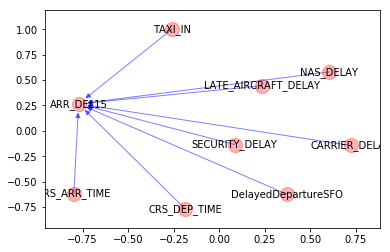

In [11]:
# update dataframe of edges and draw graph
flight_edges_df, bn = update_flights_edges_df(arr_15_from, 'ARR_DEL15',flight_edges_df)
draw_graph(flight_edges_df,'initial_bn.png')

Using regressional analysis, we conclude that ARR_DEL15 is dependent on six factors. So far, we do not have any cycles (remember that a Bayesian network consists of a directed acyclic graph), so we may proceed by moving onto finding more dependencies by choosing an arbitrary parent of ARR_DEL15.

### NAS Delay

Carrier Delay depends on

In [12]:
nas_delay_from =['MONTH', 'TAXI_OUT', 'CARRIER_DELAY','LATE_AIRCRAFT_DELAY']
regression_model(nas_delay_from, 'NAS_DELAY').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              NAS_DELAY   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     189.4
Date:                Mon, 09 Apr 2018   Prob (F-statistic):          5.69e-113
Time:                        06:13:54   Log-Likelihood:                -447.89
No. Observations:                 774   AIC:                             903.8
Df Residuals:                     770   BIC:                             922.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
MONTH                  -0.0075      0.004     -2.032      0.042      -0.015      -0.000
TAXI_OUT                0.2461      0.017     14.529      0.000       0.213       0.279
CARRIER_DELAY           0.2389      0.036      6.593      0.000       0.168       0.310
LATE_AIRCRAFT_DELAY     0.0695      0.040      1.723      0.085      -0.010       0.149
==============================================================================
Omnibus:                      213.239   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.846
Skew:                           0.538   Prob(JB):                     4.13e-16
Kurtosis:                       1.980   Cond. No.                         22.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
flight_edges_df, bn = update_flights_edges_df(nas_delay_from, 'NAS_DELAY',flight_edges_df)

No cycle found! You may proceed.


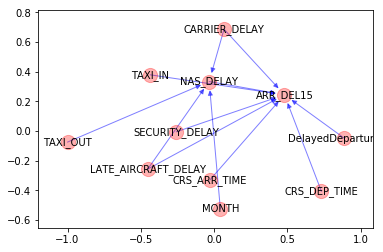

In [14]:
draw_graph(flight_edges_df, 'nas-arr_del15.png')

### Late Aircraft Delay

Now, we took a look at the variables that LATE_AIRCRAFT_DELAY rely on. From this point on, we will not display the graph.

In [15]:
late_aircraft_from = ['CRS_DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'CRS_ARR_TIME', 'NAS_DELAY', 'SECURITY_DELAY']
regression_model(late_aircraft_from, 'LATE_AIRCRAFT_DELAY').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     LATE_AIRCRAFT_DELAY   R-squared:                       0.360
Model:                             OLS   Adj. R-squared:                  0.355
Method:                  Least Squares   F-statistic:                     71.91
Date:                 Mon, 09 Apr 2018   Prob (F-statistic):           4.29e-71
Time:                         06:13:55   Log-Likelihood:                -295.80
No. Observations:                  774   AIC:                             603.6
Df Residuals:                      768   BIC:                             631.5
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
CRS_DEP_TIME       0.1913      0.028      6.812      0.000       0.136       0.246
DEP_DELAY          0.1562      0.014     11.321      0.000       0.129       0.183
TAXI_OUT          -0.0229      0.017     -1.374      0.170      -0.056       0.010
CRS_ARR_TIME       0.1521      0.026      5.943      0.000       0.102       0.202
NAS_DELAY          0.0630      0.029      2.176      0.030       0.006       0.120
SECURITY_DELAY     0.7147      0.357      2.004      0.045       0.014       1.415
==============================================================================
Omnibus:                       82.725   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              103.648
Skew:                           0.878   Prob(JB):                     3.11e-23
Kurtosis:                       2.636   Cond. No.                         50.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
flight_edges_df, bn = update_flights_edges_df(late_aircraft_from, 'LATE_AIRCRAFT_DELAY',flight_edges_df)

[('LATE_AIRCRAFT_DELAY', 'NAS_DELAY'), ('NAS_DELAY', 'LATE_AIRCRAFT_DELAY')]


Since __NAS_DELAY__ and __LATE_AIRCRAFT_DELAY__ have edges pointing to each other, we must decide which edge we are going to get rid of. The FAA (http://aspmhelp.faa.gov/index.php/Types_of_Delay) defines __NAS_DELAY__ as delay that is "within the control of the National Airspace System (NAS)," including "non-extreme weather conditions, airport operations, heavy traffic volume, air traffic control, etc." It goes on to state that delays at the destination airport that occur after Actual Gate Out time are attributed to the NAS (such as gate in delay and taxi in delay). On the other hand, FAA defines __LATE_AIRCRAFT_DELAY__ as arrival delay due to the ripple effect of an earlier delay at downstream airports is referred to as delay propagation. That is, the two seem to have no direct relationship with one another at all. Therefore, we remove both edges.

In [17]:
flight_edges_df, _ = remove_edge('NAS_DELAY', 'LATE_AIRCRAFT_DELAY', flight_edges_df)
flight_edges_df, bn = remove_edge('LATE_AIRCRAFT_DELAY', 'NAS_DELAY', flight_edges_df)


No cycle found! You may proceed.
No cycle found! You may proceed.


### Carrier Delay

In [18]:
carrier_delay_from = ['MONTH', 'CRS_DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'CRS_ARR_TIME', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY']
regression_model(carrier_delay_from, 'CARRIER_DELAY').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          CARRIER_DELAY   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     88.70
Date:                Mon, 09 Apr 2018   Prob (F-statistic):          9.46e-104
Time:                        06:13:55   Log-Likelihood:                -318.88
No. Observations:                 774   AIC:                             653.8
Df Residuals:                     766   BIC:                             691.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
MONTH              0.0096      0.004      2.659      0.008       0.003       0.017
CRS_DEP_TIME       0.1917      0.033      5.810      0.000       0.127       0.257
DEP_DELAY          0.2060      0.014     14.436      0.000       0.178       0.234
TAXI_OUT          -0.0810      0.018     -4.472      0.000      -0.117      -0.045
CRS_ARR_TIME       0.1848      0.031      6.053      0.000       0.125       0.245
WEATHER_DELAY     -0.5346      0.185     -2.887      0.004      -0.898      -0.171
NAS_DELAY          0.1865      0.030      6.238      0.000       0.128       0.245
SECURITY_DELAY    -0.3773      0.368     -1.025      0.306      -1.100       0.345
==============================================================================
Omnibus:                      141.170   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.785
Skew:                           0.231   Prob(JB):                     1.03e-08
Kurtosis:                       2.037   Cond. No.                         221.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
flight_edges_df, bn = update_flights_edges_df(carrier_delay_from, 'CARRIER_DELAY',flight_edges_df)

[('CARRIER_DELAY', 'NAS_DELAY'), ('NAS_DELAY', 'CARRIER_DELAY')]


__CARRIER_DELAY__ is within the control of the air carrier, such as: aircraft cleaning, aircraft damage, awaiting the arrival of connecting passengers or crew, baggage, bird strike, cargo loading, catering, computer, outage-carrier equipment, crew legality (pilot or attendant rest), damage by hazardous goods, engineering inspection, fueling, handling disabled passengers, late crew, lavatory servicing, maintenance, oversales, potable water servicing, removal of unruly passenger, slow boarding or seating, stowing carry-on baggage, weight and balance delays. This seems to have little to do with __NAS_DELAY__ and vice versa. Thus, we remove both edges

In [20]:
# remove both edges
flight_edges_df, _ = remove_edge('CARRIER_DELAY','NAS_DELAY', flight_edges_df)
flight_edges_df, bn = remove_edge('NAS_DELAY','CARRIER_DELAY', flight_edges_df)

No cycle found! You may proceed.
No cycle found! You may proceed.


Recall that FAA defines __LATE_AIRCRAFT_DELAY__ as arrival delay due to the ripple effect of an earlier delay at downstream airports is referred to as delay propagation. It would seem probable that a late prior aircraft could cause carrier delay but not the other way around. Thus, we only remove the edge from CARRIER_DELAY to LATE_AIRCRAFT_DELAY.

### WEATHER_DELAY

In [21]:
weather_delay_from = ['LATE_AIRCRAFT_DELAY', 'ScheduledDepartureSFO', 'DelayedArrivalPHL', 'ScheduledArrivalPHL']
regression_model(weather_delay_from, 'WEATHER_DELAY').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          WEATHER_DELAY   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     3.470
Date:                Mon, 09 Apr 2018   Prob (F-statistic):            0.00806
Time:                        06:13:55   Log-Likelihood:                 946.32
No. Observations:                 774   AIC:                            -1885.
Df Residuals:                     770   BIC:                            -1866.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
LATE_AIRCRAFT_DELAY       0.0113      0.006      1.870      0.062      -0.001       0.023
ScheduledDepartureSFO     0.0029      0.002      1.641      0.101      -0.001       0.006
DelayedArrivalPHL         0.0443      0.018      2.470      0.014       0.009       0.079
ScheduledArrivalPHL      -0.0054      0.004     -1.424      0.155      -0.013       0.002
==============================================================================
Omnibus:                     1465.223   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1105963.255
Skew:                          13.500   Prob(JB):                         0.00
Kurtosis:                     186.206   Cond. No.                         12.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
flight_edges_df, bn = update_flights_edges_df(weather_delay_from, 'WEATHER_DELAY',flight_edges_df)

No cycle found! You may proceed.


### CRS Arrival Time

In [23]:
crs_arrival_from = ['QUARTER', 'MONTH', 'DAY_OF_WEEK', 'CRS_DEP_TIME', 'TAXI_OUT', 'CARRIER_DELAY', 'LATE_AIRCRAFT_DELAY', 'ScheduledDepartureSFO']
regression_model(crs_arrival_from, 'CRS_ARR_TIME').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           CRS_ARR_TIME   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     352.6
Date:                Mon, 09 Apr 2018   Prob (F-statistic):          7.20e-251
Time:                        06:13:55   Log-Likelihood:                -311.80
No. Observations:                 774   AIC:                             639.6
Df Residuals:                     766   BIC:                             676.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
QUARTER                   0.3984      0.044      9.115      0.000       0.313       0.484
MONTH                    -0.1013      0.015     -6.768      0.000      -0.131      -0.072
DAY_OF_WEEK               0.0580      0.006      9.977      0.000       0.047       0.069
CRS_DEP_TIME             -0.7278      0.027    -27.369      0.000      -0.780      -0.676
TAXI_OUT                  0.1472      0.016      9.408      0.000       0.116       0.178
CARRIER_DELAY             0.1499      0.031      4.826      0.000       0.089       0.211
LATE_AIRCRAFT_DELAY       0.1445      0.034      4.192      0.000       0.077       0.212
ScheduledDepartureSFO     0.0266      0.009      2.977      0.003       0.009       0.044
==============================================================================
Omnibus:                       18.704   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.836
Skew:                           0.257   Prob(JB):                     4.04e-06
Kurtosis:                       3.712   Cond. No.                         32.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
flight_edges_df, bn = update_flights_edges_df(crs_arrival_from, 'CRS_ARR_TIME', flight_edges_df)

[('LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'), ('WEATHER_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'CRS_ARR_TIME'), ('CRS_ARR_TIME', 'LATE_AIRCRAFT_DELAY')]


In [25]:
flight_edges_df, bn = remove_edge('CARRIER_DELAY', 'CRS_ARR_TIME', flight_edges_df)

[('LATE_AIRCRAFT_DELAY', 'CRS_ARR_TIME'), ('CRS_ARR_TIME', 'LATE_AIRCRAFT_DELAY')]


In [26]:
flight_edges_df, bn = remove_edge('LATE_AIRCRAFT_DELAY', 'CRS_ARR_TIME', flight_edges_df)

No cycle found! You may proceed.


### CRS Departure Time

In [27]:
crs_departure_from = ['QUARTER', 'MONTH', 'DAY_OF_WEEK', 'TAXI_OUT', 'CRS_ARR_TIME', 'CARRIER_DELAY','NAS_DELAY', 'LATE_AIRCRAFT_DELAY', 'ScheduledDepartureSFO'] 
regression_model(crs_departure_from, 'CRS_DEP_TIME').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           CRS_DEP_TIME   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     217.3
Date:                Mon, 09 Apr 2018   Prob (F-statistic):          5.37e-204
Time:                        06:13:55   Log-Likelihood:                -284.34
No. Observations:                 774   AIC:                             586.7
Df Residuals:                     765   BIC:                             628.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
QUARTER                   0.2949      0.043      6.831      0.000       0.210       0.380
MONTH                    -0.0690      0.015     -4.701      0.000      -0.098      -0.040
DAY_OF_WEEK               0.0529      0.006      9.369      0.000       0.042       0.064
TAXI_OUT                  0.1479      0.017      8.791      0.000       0.115       0.181
CRS_ARR_TIME             -0.6803      0.025    -27.407      0.000      -0.729      -0.632
CARRIER_DELAY             0.1781      0.031      5.808      0.000       0.118       0.238
NAS_DELAY                -0.0378      0.029     -1.288      0.198      -0.095       0.020
LATE_AIRCRAFT_DELAY       0.1958      0.033      5.934      0.000       0.131       0.261
ScheduledDepartureSFO     0.0196      0.009      2.262      0.024       0.003       0.037
==============================================================================
Omnibus:                       41.235   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.201
Skew:                           0.489   Prob(JB):                     2.80e-12
Kurtosis:                       3.833   Cond. No.                         33.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
flight_edges_df, bn = update_flights_edges_df(crs_departure_from, 'CRS_DEP_TIME', flight_edges_df)

[('CRS_DEP_TIME', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'), ('WEATHER_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'CRS_DEP_TIME')]


In [29]:
flight_edges_df, bn = remove_edge('CARRIER_DELAY', 'CRS_DEP_TIME', flight_edges_df)

[('CRS_DEP_TIME', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'CRS_DEP_TIME')]


In [30]:
flight_edges_df, bn = remove_edge('LATE_AIRCRAFT_DELAY', 'CRS_DEP_TIME', flight_edges_df)

[('CRS_DEP_TIME', 'CRS_ARR_TIME'), ('CRS_ARR_TIME', 'CRS_DEP_TIME')]


In [31]:
flight_edges_df, bn = remove_edge('CRS_DEP_TIME', 'CRS_ARR_TIME', flight_edges_df)

No cycle found! You may proceed.


### Taxi Out

Taxi Out Time, in Minutes.

In [32]:
taxi_out_from = ['QUARTER', 'CRS_DEP_TIME', 'DEP_DELAY', 'CRS_ARR_TIME', 'CARRIER_DELAY', 'NAS_DELAY', 'LATE_AIRCRAFT_DELAY']
regression_model(taxi_out_from, 'TAXI_OUT').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TAXI_OUT   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     461.9
Date:                Mon, 09 Apr 2018   Prob (F-statistic):          4.31e-270
Time:                        06:13:55   Log-Likelihood:                -838.11
No. Observations:                 774   AIC:                             1690.
Df Residuals:                     767   BIC:                             1723.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
QUARTER                 0.1968      0.020      9.895      0.000       0.158       0.236
CRS_DEP_TIME            0.6789      0.064     10.593      0.000       0.553       0.805
DEP_DELAY              -0.0795      0.033     -2.417      0.016      -0.144      -0.015
CRS_ARR_TIME            0.6724      0.060     11.293      0.000       0.556       0.789
CARRIER_DELAY          -0.2947      0.069     -4.245      0.000      -0.431      -0.158
NAS_DELAY               0.7123      0.054     13.180      0.000       0.606       0.818
LATE_AIRCRAFT_DELAY    -0.0914      0.073     -1.259      0.208      -0.234       0.051
==============================================================================
Omnibus:                       91.135   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              166.226
Skew:                           0.737   Prob(JB):                     8.02e-37
Kurtosis:                       4.727   Cond. No.                         9.85
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
flight_edges_df, bn = update_flights_edges_df(taxi_out_from,'TAXI_OUT',flight_edges_df)

[('CRS_DEP_TIME', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'), ('WEATHER_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'NAS_DELAY'), ('NAS_DELAY', 'CRS_DEP_TIME')]


In [34]:
flight_edges_df, bn = remove_edge('TAXI_OUT', 'NAS_DELAY', flight_edges_df)

[('LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'), ('WEATHER_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'LATE_AIRCRAFT_DELAY')]


In [35]:
flight_edges_df, bn = remove_edge('TAXI_OUT', 'LATE_AIRCRAFT_DELAY', flight_edges_df)

[('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'CARRIER_DELAY')]


In [36]:
flight_edges_df, bn = remove_edge('TAXI_OUT', 'CARRIER_DELAY', flight_edges_df)

[('LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'), ('WEATHER_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'CRS_ARR_TIME'), ('CRS_ARR_TIME', 'LATE_AIRCRAFT_DELAY')]


In [37]:
flight_edges_df, bn = remove_edge('TAXI_OUT', 'CRS_ARR_TIME', flight_edges_df)

[('CRS_DEP_TIME', 'LATE_AIRCRAFT_DELAY'), ('LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'), ('WEATHER_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'CRS_DEP_TIME')]


In [38]:
flight_edges_df, bn = remove_edge('TAXI_OUT', 'CRS_DEP_TIME', flight_edges_df)

No cycle found! You may proceed.


### Taxi In

In [39]:
taxi_in_from = ['CRS_ARR_TIME', 'LATE_AIRCRAFT_DELAY', 'DelayedDepartureSFO']
regression_model(taxi_in_from, 'TAXI_IN').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                TAXI_IN   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     11.94
Date:                Mon, 09 Apr 2018   Prob (F-statistic):           1.20e-07
Time:                        06:13:55   Log-Likelihood:                -661.48
No. Observations:                 774   AIC:                             1329.
Df Residuals:                     771   BIC:                             1343.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
CRS_ARR_TIME            0.1045      0.028      3.724      0.000       0.049       0.160
LATE_AIRCRAFT_DELAY     0.0679      0.049      1.378      0.169      -0.029       0.165
DelayedDepartureSFO     0.2048      0.077      2.677      0.008       0.055       0.355
==============================================================================
Omnibus:                     1466.014   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1869567.070
Skew:                          13.191   Prob(JB):                         0.00
Kurtosis:                     242.322   Cond. No.                         3.02
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
flight_edges_df, bn = update_flights_edges_df(taxi_in_from,'TAXI_IN',flight_edges_df)

No cycle found! You may proceed.


### Calendar Quarter

We come to a rather interesting (not entirely unlikely) conclusion that CRS_DEP_TIME and CRS_ARR_TIME may directly influence QUARTER.

In [41]:
quarter_from = ['MONTH', 'DAY_OF_WEEK', 'CRS_DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'CRS_ARR_TIME'] 
regression_model(quarter_from, 'QUARTER').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                QUARTER   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 1.302e+04
Date:                Mon, 09 Apr 2018   Prob (F-statistic):               0.00
Time:                        06:13:55   Log-Likelihood:                -123.09
No. Observations:                 774   AIC:                             258.2
Df Residuals:                     768   BIC:                             286.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
MONTH            0.3254      0.003    111.288      0.000       0.320       0.331
DAY_OF_WEEK      0.0137      0.005      2.857      0.004       0.004       0.023
CRS_DEP_TIME     0.1855      0.027      6.789      0.000       0.132       0.239
DEP_DELAY        0.0204      0.011      1.859      0.063      -0.001       0.042
TAXI_OUT         0.0524      0.013      4.083      0.000       0.027       0.078
CRS_ARR_TIME     0.2426      0.026      9.398      0.000       0.192       0.293
==============================================================================
Omnibus:                      773.943   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.273
Skew:                           0.064   Prob(JB):                     1.21e-11
Kurtosis:                       1.758   Cond. No.                         29.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
flight_edges_df, bn = update_flights_edges_df(quarter_from, 'QUARTER',flight_edges_df)

[('LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'), ('WEATHER_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'QUARTER'), ('QUARTER', 'CRS_ARR_TIME'), ('CRS_ARR_TIME', 'LATE_AIRCRAFT_DELAY')]


In [43]:
flight_edges_df, bn = remove_edge('TAXI_IN', 'QUARTER', flight_edges_df)

[('LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'), ('WEATHER_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'QUARTER'), ('QUARTER', 'CRS_ARR_TIME'), ('CRS_ARR_TIME', 'LATE_AIRCRAFT_DELAY')]


In [44]:
flight_edges_df, bn = remove_edge('TAXI_OUT', 'QUARTER', flight_edges_df)

[('CRS_DEP_TIME', 'QUARTER'), ('QUARTER', 'CRS_ARR_TIME'), ('CRS_ARR_TIME', 'CRS_DEP_TIME')]


In [45]:
flight_edges_df, bn = remove_edge('CRS_DEP_TIME', 'QUARTER', flight_edges_df)

[('CRS_ARR_TIME', 'QUARTER'), ('QUARTER', 'CRS_ARR_TIME')]


In [46]:
flight_edges_df, bn = remove_edge('CRS_ARR_TIME', 'QUARTER', flight_edges_df)

No cycle found! You may proceed.


### Departure Delay

This is the difference in minutes between scheduled and actual departure time. Early departures show negative numbers.

Departure time is the time recorded when the plane's parking brakes are released, which is after doors are closed and just prior to the plane beginning to taxi. That is, departure time starts right before a plan leaves its gate. Therefore, while it is likely that a difference in CRS departure time and actual departure time causes an NAS delay, it is impossible for NAS delay to influence the departure time difference. Thus, we remove the edge from NAS_DELAY to DEP_DELAY.

In [47]:
departure_delay_from = ['QUARTER', 'MONTH', 'CRS_DEP_TIME', 'TAXI_OUT', 'CARRIER_DELAY',  'LATE_AIRCRAFT_DELAY'] 
regression_model(departure_delay_from, 'DEP_DELAY').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              DEP_DELAY   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     77.57
Date:                Mon, 09 Apr 2018   Prob (F-statistic):           1.04e-75
Time:                        06:13:55   Log-Likelihood:                -903.23
No. Observations:                 774   AIC:                             1818.
Df Residuals:                     768   BIC:                             1846.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
QUARTER                 0.2002      0.091      2.205      0.028       0.022       0.378
MONTH                  -0.0890      0.032     -2.796      0.005      -0.151      -0.027
CRS_DEP_TIME            0.1474      0.057      2.605      0.009       0.036       0.258
TAXI_OUT               -0.1057      0.033     -3.211      0.001      -0.170      -0.041
CARRIER_DELAY           0.8734      0.066     13.187      0.000       0.743       1.003
LATE_AIRCRAFT_DELAY     0.7060      0.074      9.575      0.000       0.561       0.851
==============================================================================
Omnibus:                     2009.434   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.804
Skew:                           0.350   Prob(JB):                     2.56e-16
Kurtosis:                       1.682   Cond. No.                         29.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
flight_edges_df, bn = update_flights_edges_df(departure_delay_from,'DEP_DELAY',flight_edges_df)

[('LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'), ('WEATHER_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'DEP_DELAY'), ('DEP_DELAY', 'LATE_AIRCRAFT_DELAY')]


In [49]:
flight_edges_df, bn = remove_edge('DEP_DELAY', 'LATE_AIRCRAFT_DELAY', flight_edges_df)

[('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'DEP_DELAY'), ('DEP_DELAY', 'CARRIER_DELAY')]


In [50]:
flight_edges_df, bn = remove_edge('DEP_DELAY', 'CARRIER_DELAY', flight_edges_df)

[('TAXI_OUT', 'DEP_DELAY'), ('DEP_DELAY', 'TAXI_OUT')]


In [51]:
flight_edges_df, bn = remove_edge('TAXI_OUT', 'DEP_DELAY', flight_edges_df)

[('LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'), ('WEATHER_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'QUARTER'), ('QUARTER', 'CRS_ARR_TIME'), ('CRS_ARR_TIME', 'LATE_AIRCRAFT_DELAY')]


In [52]:
flight_edges_df, bn = remove_edge('DEP_DELAY', 'QUARTER', flight_edges_df)

No cycle found! You may proceed.


### DelayedDepartureSFO

In [53]:
delayed_SFO_from = ['TAXI_IN', 'ScheduledDepartureSFO', 'ScheduledArrivalPHL']
regression_model(delayed_SFO_from, 'DelayedDepartureSFO').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     DelayedDepartureSFO   R-squared:                       0.284
Model:                             OLS   Adj. R-squared:                  0.281
Method:                  Least Squares   F-statistic:                     102.1
Date:                 Mon, 09 Apr 2018   Prob (F-statistic):           1.19e-55
Time:                         06:13:55   Log-Likelihood:                 27.334
No. Observations:                  774   AIC:                            -48.67
Df Residuals:                      771   BIC:                            -34.71
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
TAXI_IN                   0.0322      0.015      2.204      0.028       0.004       0.061
ScheduledDepartureSFO     0.0768      0.006     13.681      0.000       0.066       0.088
ScheduledArrivalPHL       0.0267      0.009      3.035      0.002       0.009       0.044
==============================================================================
Omnibus:                      314.314   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1157.664
Skew:                           1.948   Prob(JB):                    4.13e-252
Kurtosis:                       7.552   Cond. No.                         3.08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
flight_edges_df, bn = update_flights_edges_df(delayed_SFO_from,'DelayedDepartureSFO',flight_edges_df)

[('TAXI_IN', 'DelayedDepartureSFO'), ('DelayedDepartureSFO', 'TAXI_IN')]


In [55]:
flight_edges_df, bn = remove_edge('TAXI_IN', 'DelayedDepartureSFO', flight_edges_df)

No cycle found! You may proceed.


###   DelayedArrivalPHL

In [56]:
delayed_PHL_from = ['DEP_DELAY', 'TAXI_OUT', 'WEATHER_DELAY', 'ScheduledDepartureSFO', 'ScheduledArrivalPHL']
regression_model(delayed_PHL_from, 'DelayedArrivalPHL').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      DelayedArrivalPHL   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     179.8
Date:                Mon, 09 Apr 2018   Prob (F-statistic):          1.13e-126
Time:                        06:13:55   Log-Likelihood:                 422.41
No. Observations:                 774   AIC:                            -834.8
Df Residuals:                     769   BIC:                            -811.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
DEP_DELAY                -0.0108      0.005     -2.088      0.037      -0.021      -0.001
TAXI_OUT                 -0.0179      0.004     -4.996      0.000      -0.025      -0.011
WEATHER_DELAY             0.1926      0.071      2.723      0.007       0.054       0.331
ScheduledDepartureSFO    -0.0134      0.004     -3.836      0.000      -0.020      -0.007
ScheduledArrivalPHL       0.1580      0.006     28.630      0.000       0.147       0.169
==============================================================================
Omnibus:                      263.483   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2076.142
Skew:                           1.314   Prob(JB):                         0.00
Kurtosis:                      10.581   Cond. No.                         28.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:
flight_edges_df, bn = update_flights_edges_df(delayed_PHL_from,'DelayedArrivalPHL',flight_edges_df)

[('WEATHER_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'DelayedArrivalPHL'), ('DelayedArrivalPHL', 'WEATHER_DELAY')]


In [58]:
flight_edges_df, bn = remove_edge('DelayedArrivalPHL', 'WEATHER_DELAY', flight_edges_df)

No cycle found! You may proceed.


### Number of Scheduled Departures from SFO When Delayed Flight is scheduled to Depart

In [59]:
scheduled_SFO_from = ['CRS_DEP_TIME', 'CRS_ARR_TIME', 'DelayedDepartureSFO', 'DelayedArrivalPHL', 'ScheduledArrivalPHL']
regression_model(scheduled_SFO_from, 'ScheduledDepartureSFO').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     ScheduledDepartureSFO   R-squared:                       0.431
Model:                               OLS   Adj. R-squared:                  0.427
Method:                    Least Squares   F-statistic:                     116.4
Date:                   Mon, 09 Apr 2018   Prob (F-statistic):           1.30e-91
Time:                           06:13:55   Log-Likelihood:                -1281.5
No. Observations:                    774   AIC:                             2573.
Df Residuals:                        769   BIC:                             2596.
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
CRS_DEP_TIME            0.3910      0.074      5.274      0.000       0.245       0.537
CRS_ARR_TIME            0.4670      0.063      7.378      0.000       0.343       0.591
DelayedDepartureSFO     2.2968      0.177     12.993      0.000       1.950       2.644
DelayedArrivalPHL      -0.8902      0.320     -2.778      0.006      -1.519      -0.261
ScheduledArrivalPHL     0.4264      0.070      6.124      0.000       0.290       0.563
==============================================================================
Omnibus:                      246.315   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              548.574
Skew:                           1.781   Prob(JB):                    7.56e-120
Kurtosis:                       5.080   Cond. No.                         8.27
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [60]:
flight_edges_df, bn = update_flights_edges_df(scheduled_SFO_from,'ScheduledDepartureSFO',flight_edges_df)

[('WEATHER_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'DelayedArrivalPHL'), ('DelayedArrivalPHL', 'ScheduledDepartureSFO'), ('ScheduledDepartureSFO', 'WEATHER_DELAY')]


In [61]:
flight_edges_df, bn = remove_edge('DelayedArrivalPHL', 'ScheduledDepartureSFO', flight_edges_df)

[('CRS_DEP_TIME', 'ScheduledDepartureSFO'), ('ScheduledDepartureSFO', 'CRS_ARR_TIME'), ('CRS_ARR_TIME', 'CRS_DEP_TIME')]


In [62]:
flight_edges_df, bn = remove_edge('ScheduledDepartureSFO', 'CRS_ARR_TIME', flight_edges_df)

[('CRS_DEP_TIME', 'ScheduledDepartureSFO'), ('ScheduledDepartureSFO', 'CRS_DEP_TIME')]


In [63]:
flight_edges_df, bn = remove_edge('ScheduledDepartureSFO', 'CRS_DEP_TIME', flight_edges_df)

[('ScheduledDepartureSFO', 'DelayedDepartureSFO'), ('DelayedDepartureSFO', 'ScheduledDepartureSFO')]


In [64]:
flight_edges_df, bn = remove_edge('DelayedDepartureSFO', 'ScheduledDepartureSFO', flight_edges_df)

No cycle found! You may proceed.


### Number of Scheduled Arrivals at PHL When Delayed Flight is scheduled to Depart

In [65]:
scheduled_PHL_from = ['DAY_OF_WEEK', 'DEP_DELAY', 'TAXI_OUT', 'WEATHER_DELAY', 'DelayedDepartureSFO', 'ScheduledDepartureSFO', 'DelayedArrivalPHL']
regression_model(scheduled_PHL_from, 'ScheduledArrivalPHL').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     ScheduledArrivalPHL   R-squared:                       0.649
Model:                             OLS   Adj. R-squared:                  0.646
Method:                  Least Squares   F-statistic:                     202.4
Date:                 Mon, 09 Apr 2018   Prob (F-statistic):          1.53e-169
Time:                         06:13:55   Log-Likelihood:                -740.30
No. Observations:                  774   AIC:                             1495.
Df Residuals:                      767   BIC:                             1527.
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
DAY_OF_WEEK               0.0272      0.009      3.177      0.002       0.010       0.044
DEP_DELAY                 0.0302      0.024      1.275      0.203      -0.016       0.077
TAXI_OUT                  0.0956      0.022      4.256      0.000       0.052       0.140
WEATHER_DELAY            -0.5707      0.319     -1.788      0.074      -1.197       0.056
DelayedDepartureSFO       0.2844      0.097      2.942      0.003       0.095       0.474
ScheduledDepartureSFO     0.1080      0.017      6.257      0.000       0.074       0.142
DelayedArrivalPHL         3.2212      0.113     28.421      0.000       2.999       3.444
==============================================================================
Omnibus:                       76.309   Durbin-Watson:                   2.079
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              182.596
Skew:                           0.546   Prob(JB):                     2.24e-40
Kurtosis:                       5.114   Cond. No.                         65.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [66]:
flight_edges_df, bn = update_flights_edges_df(scheduled_PHL_from,'ScheduledArrivalPHL',flight_edges_df)

[('WEATHER_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'DelayedArrivalPHL'), ('DelayedArrivalPHL', 'ScheduledArrivalPHL'), ('ScheduledArrivalPHL', 'WEATHER_DELAY')]


In [67]:
flight_edges_df, bn = remove_edge('ScheduledArrivalPHL', 'WEATHER_DELAY', flight_edges_df)

[('ScheduledArrivalPHL', 'DelayedDepartureSFO'), ('DelayedDepartureSFO', 'ScheduledArrivalPHL')]


In [68]:
flight_edges_df, bn = remove_edge('DelayedDepartureSFO', 'ScheduledArrivalPHL', flight_edges_df)

[('DelayedArrivalPHL', 'ScheduledArrivalPHL'), ('ScheduledArrivalPHL', 'DelayedArrivalPHL')]


In [69]:
flight_edges_df, bn = remove_edge('DelayedArrivalPHL', 'ScheduledArrivalPHL', flight_edges_df)

[('WEATHER_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'TAXI_OUT'), ('TAXI_OUT', 'ScheduledArrivalPHL'), ('ScheduledArrivalPHL', 'ScheduledDepartureSFO'), ('ScheduledDepartureSFO', 'WEATHER_DELAY')]


In [70]:
flight_edges_df, bn = remove_edge('TAXI_OUT', 'ScheduledArrivalPHL', flight_edges_df)

[('WEATHER_DELAY', 'CARRIER_DELAY'), ('CARRIER_DELAY', 'DEP_DELAY'), ('DEP_DELAY', 'ScheduledArrivalPHL'), ('ScheduledArrivalPHL', 'ScheduledDepartureSFO'), ('ScheduledDepartureSFO', 'WEATHER_DELAY')]


In [71]:
flight_edges_df, bn = remove_edge('DEP_DELAY', 'ScheduledArrivalPHL', flight_edges_df)

[('WEATHER_DELAY', 'ScheduledArrivalPHL'), ('ScheduledArrivalPHL', 'ScheduledDepartureSFO'), ('ScheduledDepartureSFO', 'WEATHER_DELAY')]


In [72]:
flight_edges_df, bn = remove_edge('WEATHER_DELAY', 'ScheduledArrivalPHL', flight_edges_df)

[('ScheduledDepartureSFO', 'ScheduledArrivalPHL'), ('ScheduledArrivalPHL', 'ScheduledDepartureSFO')]


In [73]:
flight_edges_df, bn = remove_edge('ScheduledDepartureSFO', 'ScheduledArrivalPHL', flight_edges_df)
flight_edges_df, bn = remove_edge('ScheduledArrivalPHL', 'ScheduledDepartureSFO', flight_edges_df)

No cycle found! You may proceed.
No cycle found! You may proceed.


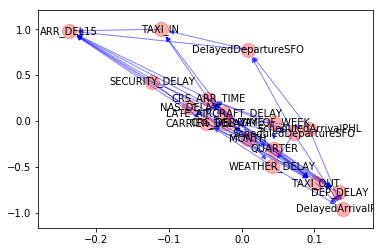

In [74]:
draw_graph(flight_edges_df,'final_bn.png')

In [75]:
print('This graph is a DAG :', nx.is_directed_acyclic_graph(bn),'\nThis edge is a tree :', nx.is_tree(bn))

This graph is a DAG : True 
This edge is a tree : False


In [76]:
# nodes
nodes_li = list(set(list(flight_edges_df['from_node'])+list(flight_edges_df['to_node'])))
nodes_df = pd.DataFrame(nodes_li)
nodes_df.columns = ['nodes']
flight_edges_df.columns=['Source','Target']
# save as csv
flight_edges_df.to_csv('edges.csv',index=False)
nodes_df.to_csv('nodes.csv',index=False)
# numbers to print
print('There are', nodes_df.shape[0], 'nodes and', flight_edges_df.shape[0], 'edges in this graph.')

There are 18 nodes and 54 edges in this graph.
